In [1]:
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns; sns.set()
import json
%matplotlib inline

import keras
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.optimizers import Adam
import salty
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from random import shuffle
import pandas as pd
import random

from keras import backend as K
from keras.objectives import binary_crossentropy #objs or losses
from keras.models import Model
from keras.layers import Input, Dense, Lambda
from keras.layers.core import Dense, Activation, Flatten, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import GRU
from keras.layers.convolutional import Convolution1D

from rdkit import Chem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
from rdkit.Chem import Draw

/home/wesleybeckner/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def Encoder(x, latent_rep_size, smile_max_length, epsilon_std = 0.01):
    h = Convolution1D(9, 9, activation = 'relu', name='conv_1')(x)
    h = Convolution1D(9, 9, activation = 'relu', name='conv_2')(h)
    h = Convolution1D(10, 11, activation = 'relu', name='conv_3')(h)
    h = Flatten(name = 'flatten_1')(h)
    h = Dense(435, activation = 'relu', name = 'dense_1')(h)

    def sampling(args):
        z_mean_, z_log_var_ = args
        batch_size = K.shape(z_mean_)[0]
        epsilon = K.random_normal(shape=(batch_size, latent_rep_size),
                                  mean=0., stddev = epsilon_std)
        return z_mean_ + K.exp(z_log_var_ / 2) * epsilon

    z_mean = Dense(latent_rep_size, name='z_mean', activation = 'linear')(h)
    z_log_var = Dense(latent_rep_size, name='z_log_var', activation = 'linear')(h)

    def vae_loss(x, x_decoded_mean):
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        xent_loss = smile_max_length * binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - \
                                 K.exp(z_log_var), axis = -1)
        return xent_loss + kl_loss

    return (vae_loss, Lambda(sampling, output_shape=(latent_rep_size,),
                             name='lambda')([z_mean, z_log_var]))

def Decoder(z, latent_rep_size, smile_max_length, charset_length):
    h = Dense(latent_rep_size, name='latent_input', activation = 'relu')(z)
    h = RepeatVector(smile_max_length, name='repeat_vector')(h)
    h = GRU(501, return_sequences = True, name='gru_1')(h)
    h = GRU(501, return_sequences = True, name='gru_2')(h)
    h = GRU(501, return_sequences = True, name='gru_3')(h)
    return TimeDistributed(Dense(charset_length, activation='softmax'),
                           name='decoded_mean')(h)

In [3]:
# if loading previous model
smile_max_length = 51
f = open("../data/1mil_GDB17.json","r")
char_to_index = json.loads(f.read())
char_set = set(char_to_index.keys())
char_list = list(char_to_index.keys())
index_to_char = dict((i, c) for i, c in enumerate(char_list))
chars_in_dict = len(char_list)

In [4]:
x = Input(shape=(smile_max_length, len(char_set)))
_, z = Encoder(x, latent_rep_size=292, smile_max_length=smile_max_length)
encoder = Model(x, z)

encoded_input looks like a dummy layer here:

In [5]:
encoded_input = Input(shape=(292,))
decoder = Model(encoded_input, Decoder(encoded_input, latent_rep_size=292,
                                       smile_max_length=smile_max_length,
                 charset_length=len(char_set)))

create a separate autoencoder model that combines the encoder and decoder (I guess the former cells are for accessing those separate parts of the model)

In [6]:
x1 = Input(shape=(smile_max_length, len(char_set)), name='input_1')
vae_loss, z1 = Encoder(x1, latent_rep_size=292, smile_max_length=smile_max_length)
autoencoder = Model(x1, Decoder(z1, latent_rep_size=292,
                                       smile_max_length=smile_max_length,
                 charset_length=len(char_set)))

we compile and fit

In [7]:
autoencoder.compile(optimizer='Adam', loss=vae_loss, metrics =['accuracy'])

In [8]:
ls ../data

1Mil_GDB17_Cation_1.h5                1Mil_GDB17_split_500k.h5
1Mil_GDB17.h5                         Bootstrap_1Mil_Cation_1.h5
1mil_GDB17.json                       Bootstrap_250k_Cation_1.h5
1Mil_GDB17_split_500k_cation_500k.h5  N+_GDB17.h5


In [9]:
vae_models = ['Bootstrap_250k_Cation_1.h5', 'Bootstrap_1Mil_Cation_1.h5',
    '1Mil_GDB17.h5', '1Mil_GDB17_split_500k.h5', '1Mil_GDB17_split_500k_cation_500k.h5']

In [10]:
#What are some metrics we may be interested in for a generator?
#How many unique structures can be generated for: (1) a given cation seed/all available cation seeds, (2) a target property value

In [11]:
def sample(a, temperature=1.0):
    # helper function to sample an index from a probability array
#     a = np.log(a) / temperature
#     a = np.exp(a) / np.sum(np.exp(a))
#     return np.argmax(np.random.multinomial(1, a, 1))
    # work around from https://github.com/llSourcell/How-to-Generate-Music-Demo/issues/4
    a = np.log(a) / temperature 
    dist = np.exp(a)/np.sum(np.exp(a)) 
    choices = range(len(a)) 
    return np.random.choice(choices, p=dist)

def pad_smiles(smiles_string, smile_max_length):
     if len(smiles_string) < smile_max_length:
            return smiles_string + " " * (smile_max_length - len(smiles_string))

In [12]:
properties = ['density', 'cpt', 'viscosity', 'thermal_conductivity',
              'melting_point']
props = properties
devmodel = salty.aggregate_data(props, merge='Union')
devmodel.Data['smiles_string'] = devmodel.Data['smiles-cation']
cations = devmodel.Data['smiles_string'].drop_duplicates()
cations = cations.reset_index(drop=True)
print(cations.shape)

(276,)


In [20]:
autoencoder.load_weights("../data/{}".format(vae_models[4]))

In [14]:
def decode_cation(vae, smi, temp=0.5):
    """
    vae: variational autoencoder to encode/decode input
    smi: smiles string to encode
    temp: temperature at which to perform sampling
    """
    smi = pad_smiles(smi, smile_max_length)
    autoencoder = vae
    Z = np.zeros((1, smile_max_length, len(char_list)), dtype=np.bool)
    for t, char in enumerate(smi):
        Z[0, t, char_to_index[char]] = 1
    string = ""
    for i in autoencoder.predict(Z):
        for j in i:
            index = sample(j, temperature=temp)
            string += index_to_char[index]
    return string

In [56]:
smi = pad_smiles(cations[0], smile_max_length)

Z = np.zeros((1, smile_max_length, len(char_list)), dtype=np.bool)
for t, char in enumerate(smi):
    Z[0, t, char_to_index[char]] = 1
string = ""
for i in autoencoder.predict(Z):
#     print(i)
    for j in i:
        print(j)
        index = sample(j, temperature=0.5)
        print(index_to_char[index])
        string += index_to_char[index]

[9.97990489e-01 7.10482767e-04 1.08492513e-08 4.79885102e-07
 1.12418085e-03 5.40359801e-09 6.30587715e-09 5.58059014e-07
 1.01722417e-05 1.30895970e-07 1.10593473e-05 1.77622788e-08
 8.17391754e-09 3.30115398e-07 1.04788423e-05 3.09240789e-09
 2.34290098e-07 9.21945002e-07 1.02281945e-07 5.72573981e-06
 6.02269381e-08 3.07243226e-08 4.20659924e-10 2.53409075e-06
 6.06007111e-09 5.51129642e-10 1.74842907e-09 1.48398167e-05
 1.13648028e-04 5.88585806e-07 2.23561506e-06 1.05182288e-07
 5.22594178e-07]
C
[9.42618608e-01 1.51206376e-02 7.50829656e-07 2.46232434e-04
 1.76827218e-02 1.14739729e-09 1.09931320e-09 6.07541355e-04
 1.43935860e-04 4.00527789e-08 3.66789917e-03 1.78780851e-06
 1.33106004e-09 1.11878883e-07 5.53161930e-03 3.76017661e-09
 1.63700406e-05 1.57998807e-06 1.82255079e-07 2.45192325e-07
 2.81185316e-06 1.89042723e-07 4.32781866e-10 1.37974503e-05
 1.58744973e-09 2.37953213e-10 3.70926116e-08 1.41708739e-02
 1.17108275e-05 4.57468814e-05 1.06392290e-04 6.08871346e-07
 7.66

In [25]:
i

array([[9.9822193e-01, 6.9627661e-04, 9.8390291e-09, ..., 1.9450390e-06,
        9.3824568e-08, 4.8342577e-07],
       [9.5163304e-01, 1.3748571e-02, 6.4468060e-07, ..., 9.4522999e-05,
        4.9000818e-07, 5.8401920e-06],
       [6.6823018e-01, 1.3178137e-01, 1.2346545e-07, ..., 3.9378941e-05,
        2.4151623e-06, 7.3954056e-05],
       ...,
       [7.9312883e-08, 1.0403864e-08, 2.6376873e-10, ..., 1.0764340e-08,
        1.1455159e-10, 3.9543634e-13],
       [2.4434691e-08, 2.6327941e-08, 2.1152451e-10, ..., 1.6959225e-07,
        1.9939837e-10, 7.9809819e-13],
       [7.0005939e-08, 2.4097796e-08, 1.1892164e-10, ..., 3.9041840e-08,
        4.6232149e-10, 2.5874569e-12]], dtype=float32)

In [15]:
cation_samples = []
for smi_index, smi in enumerate(cations):
    string = decode_cation(autoencoder, smi, temp=1)
    cation_samples.append(string)

CC(C)CCCCC1OCCCC1=COCN11CC   C    [N+ 2 CC CC      
CCC1CCCC1CCCCCCCCCO                                
C1OC12CCcCCCCCCC2O                                 


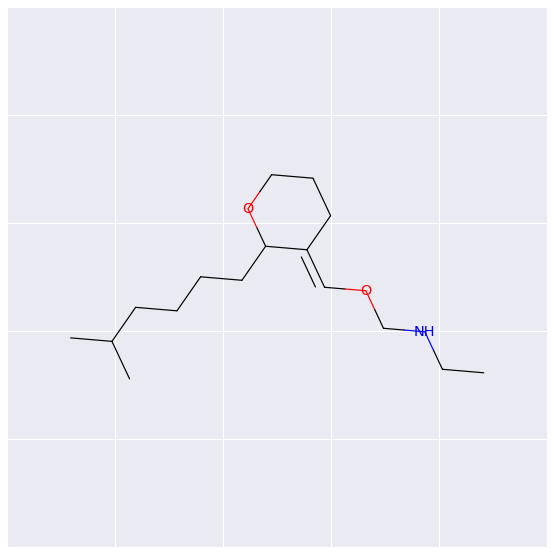

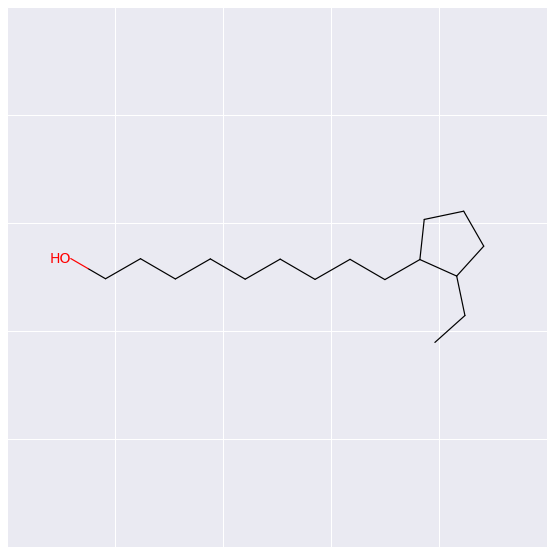

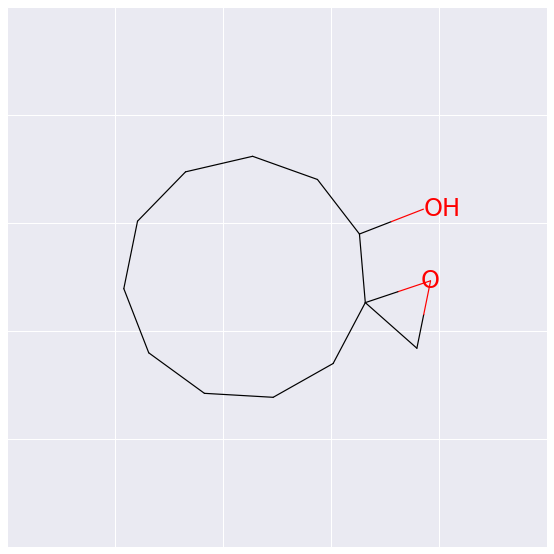

In [16]:
% matplotlib inline
rdkit_mols=[]
for smi in cation_samples:    
    try:
        sampled = Chem.MolFromSmiles(smi)
        Draw.MolToMPL(sampled)
        rdkit_mols.append(smi)
        print(smi)
    except:
        pass

In [17]:
cation_samples

['CCCC1N+CCc2C(cc()N#O                               ',
 'CC(n((C[nO]1(C=CCCC                                ',
 'CC1Cn1CC[C+]11(CC  C                               ',
 'CCCC(=O)NO]CCCCCOC    C                            ',
 'CCCCCC2=C)C1CCCC=NNCN  C                           ',
 'C2=C2=CC==3(=+C1=C(C1(1=CNC1N1CC=O=C               ',
 'C2=C2=C3=C2[=CO1CC(C)((=14N1=1)OCO)=O              ',
 'CCC1NCCNCC[PO](3CNCC4N(3CC3=C1CCC      C C         ',
 'CCCCCCCCn11c[nS]CCCOC                              ',
 'CCCCCCO)[CO]2(CC3N                                 ',
 'CCCON=OC+]((=CCCCCC C                              ',
 'C#1CCCCCcc[n+1(C1)N                                ',
 'CCOC[C+]CcCcC(NCC  N                               ',
 'CCC1(C(()(O])C1COCC                                ',
 'OC1(C(C(CNC1C2CCCCCO1C  C  C                       ',
 'CC1CCCOC2nC=1cccc(cC))#                            ',
 'CCCCCCCNC=n1cNCCC]Cc))C                            ',
 'CCC((CCCC1CC31C3NONO12  C                     

/home/wesleybeckner/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


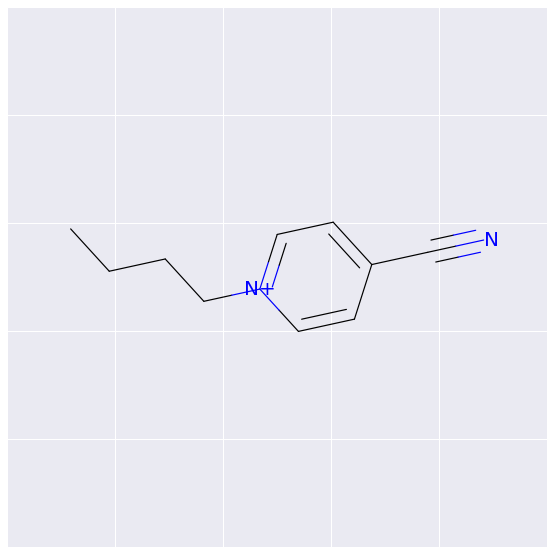

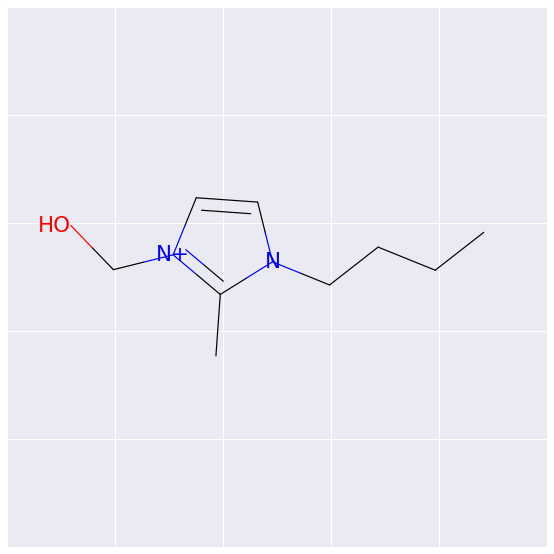

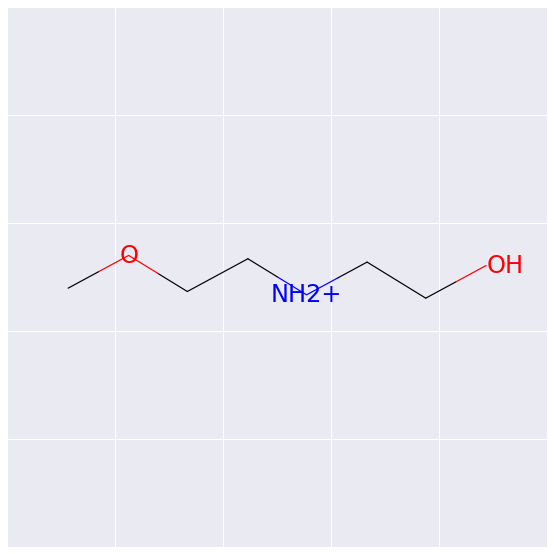

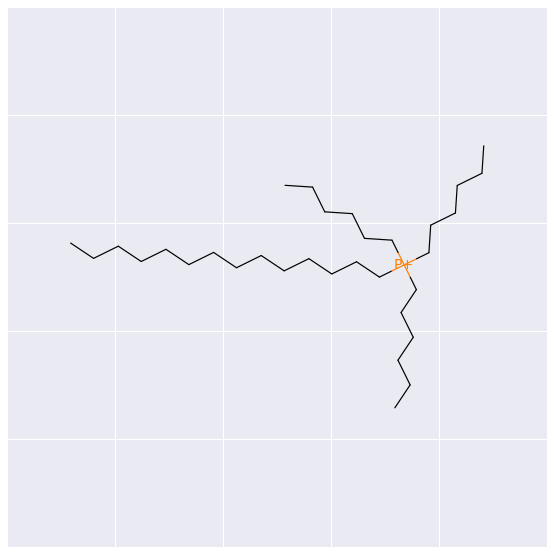

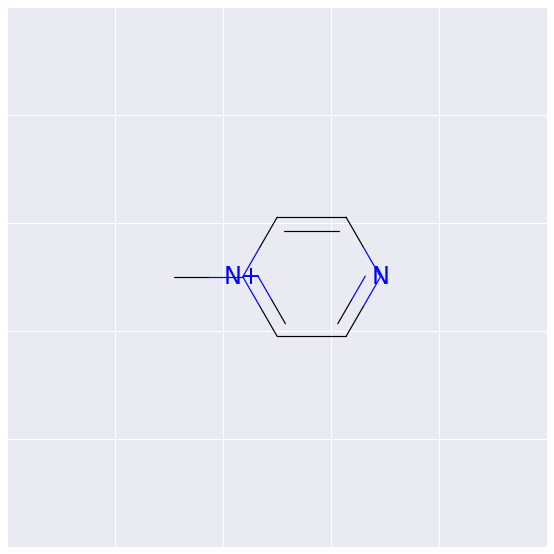

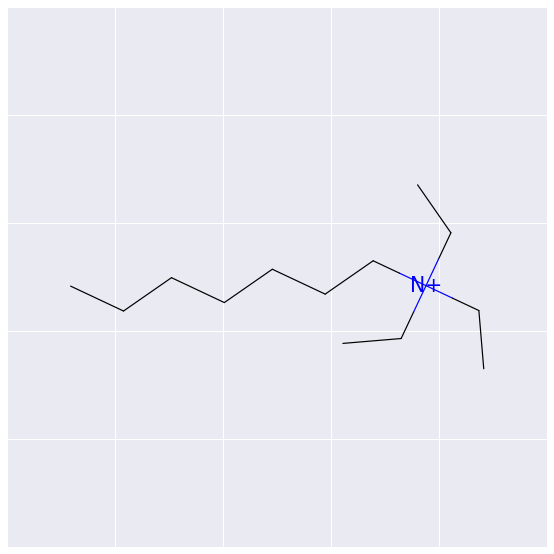

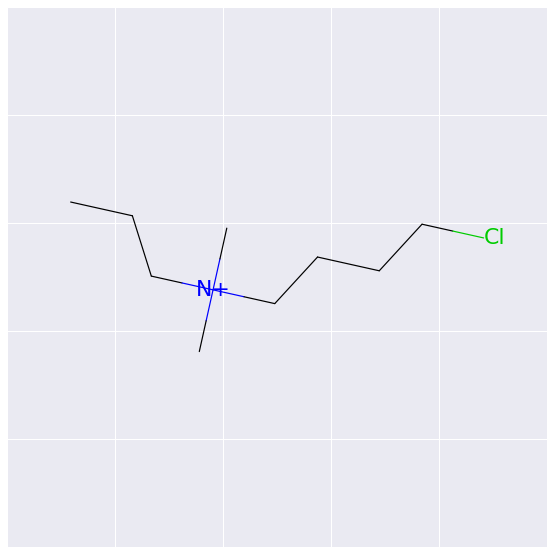

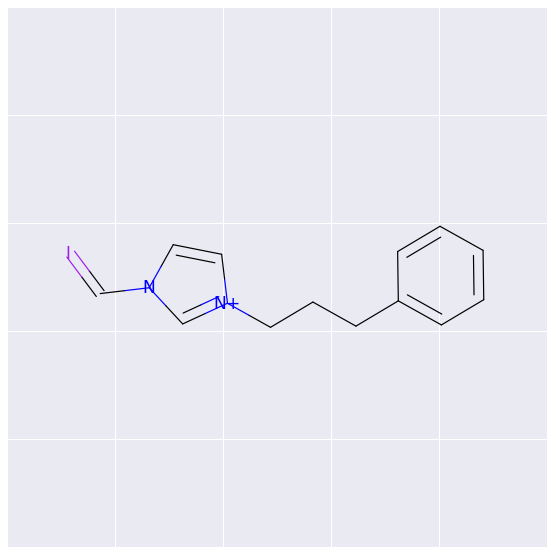

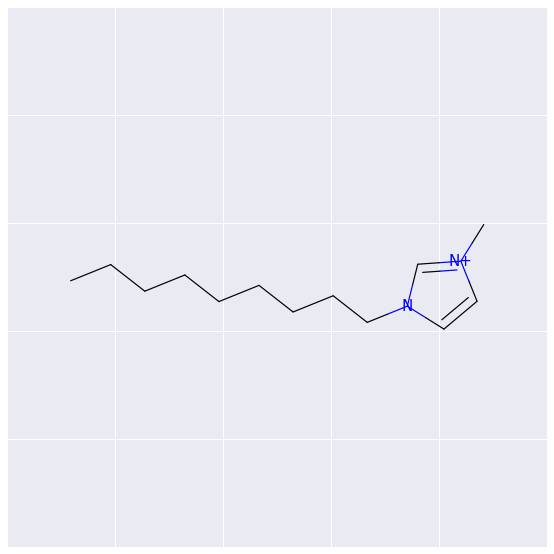

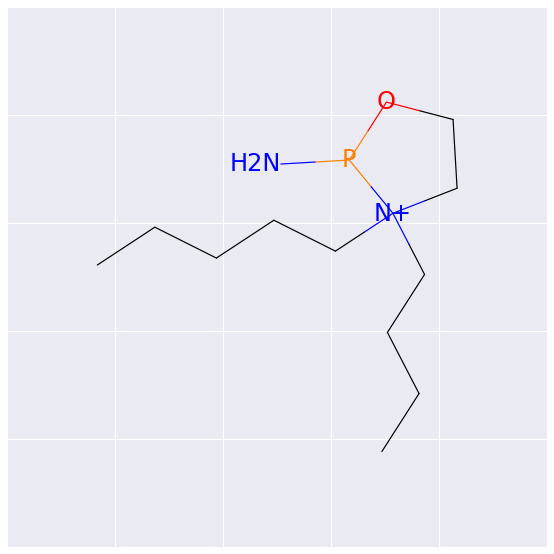

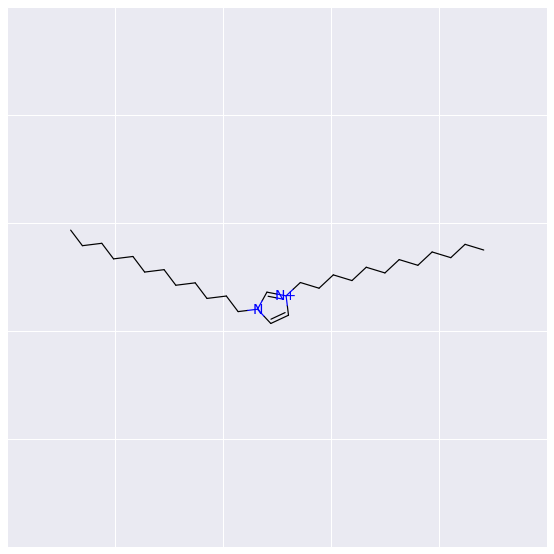

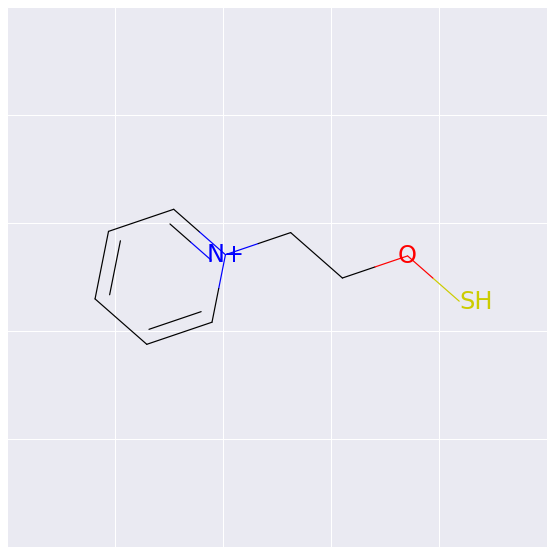

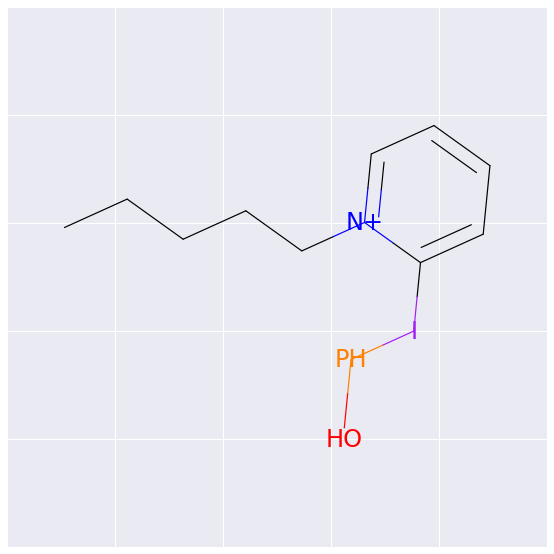

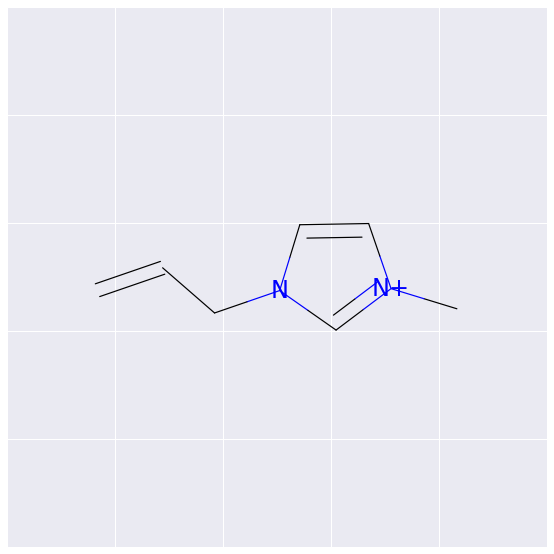

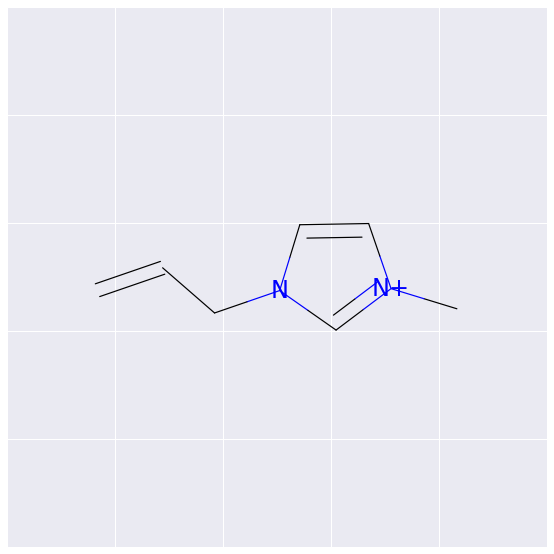

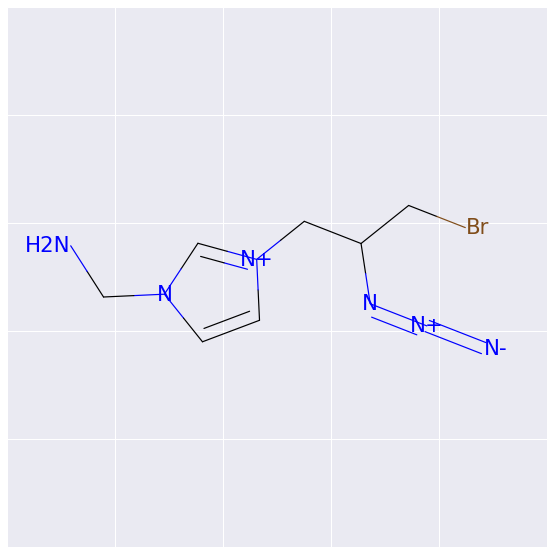

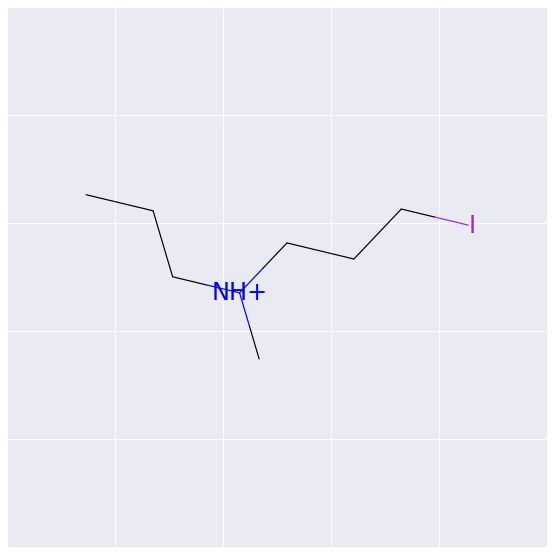

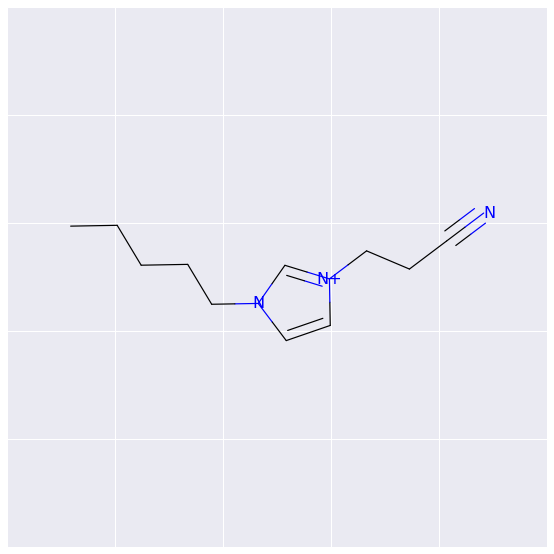

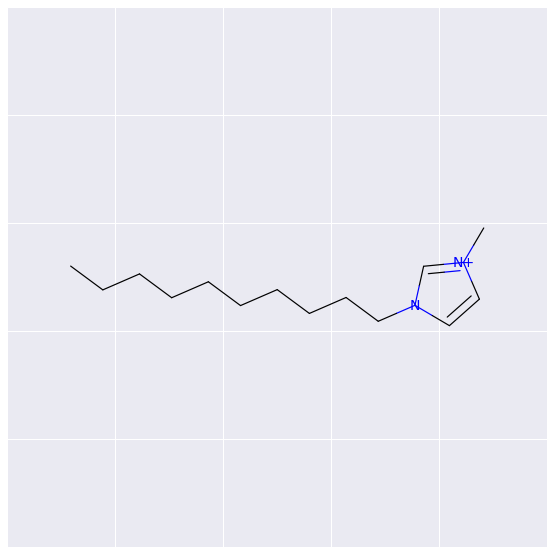

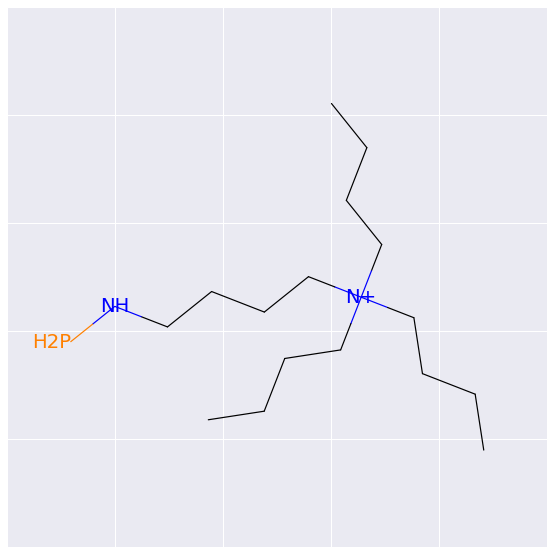

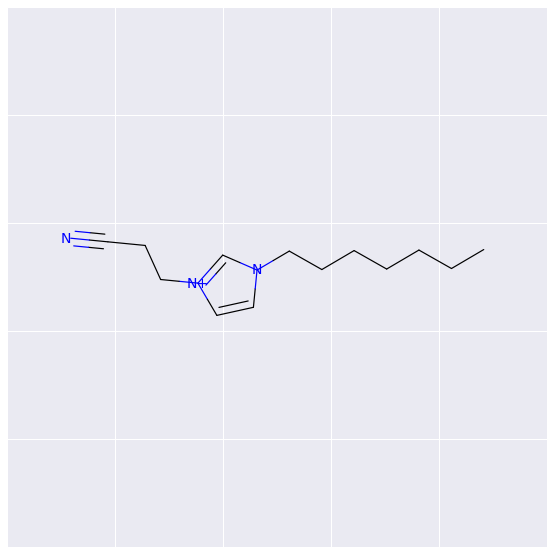

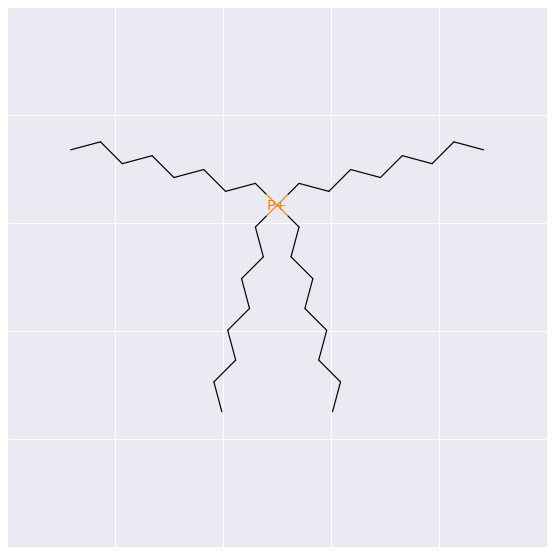

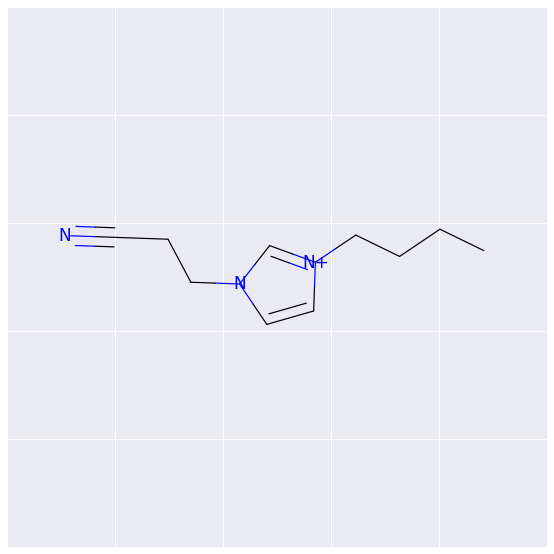

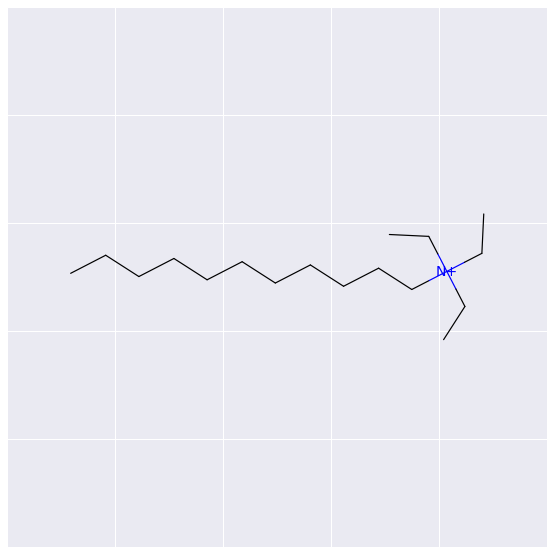

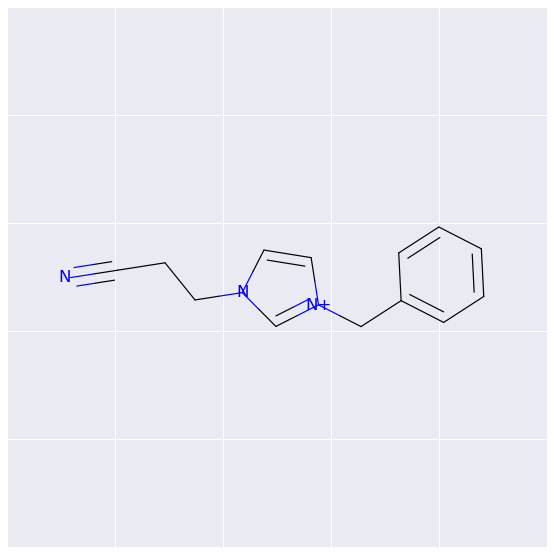

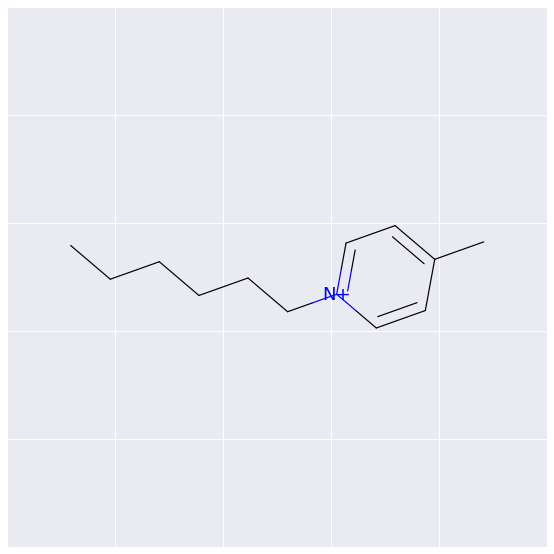

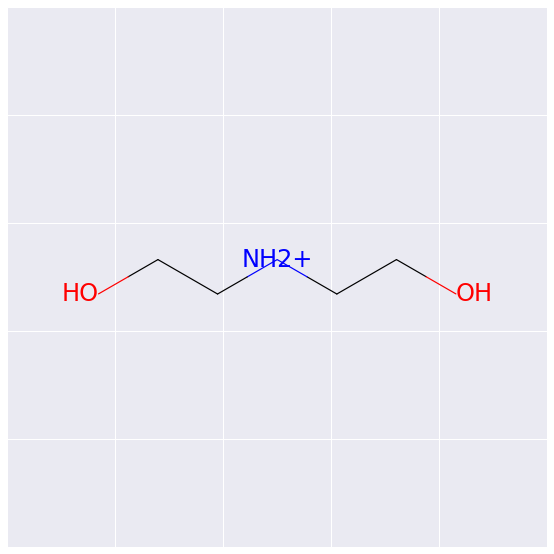

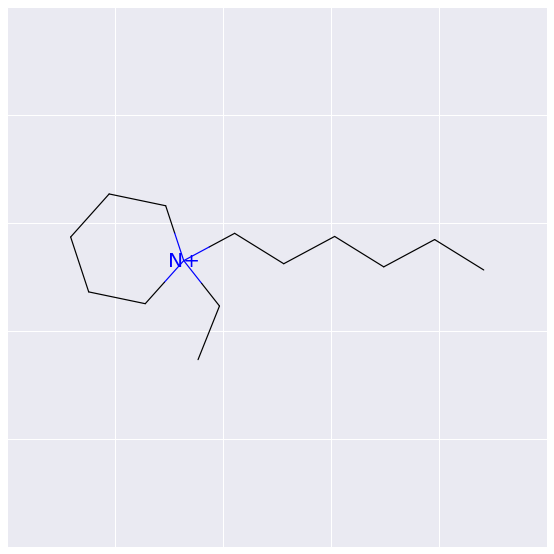

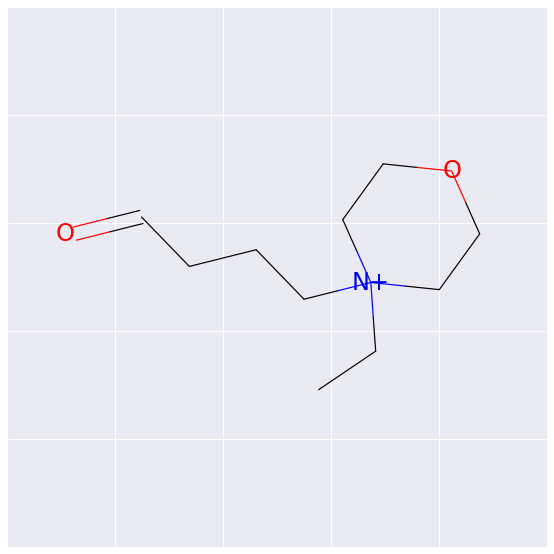

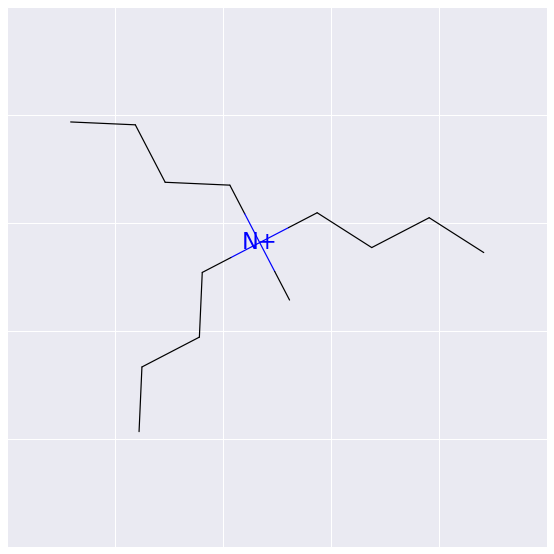

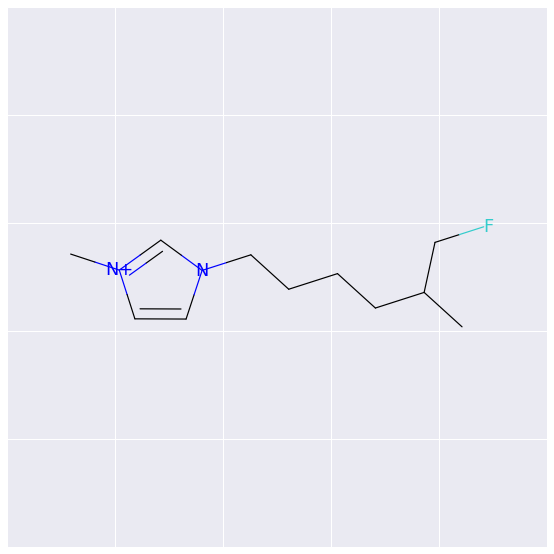

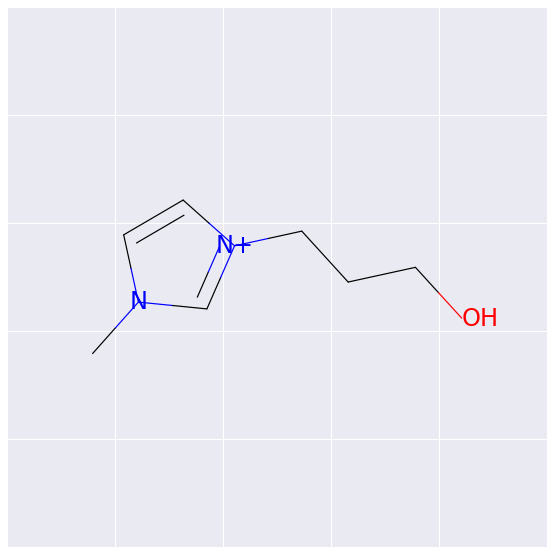

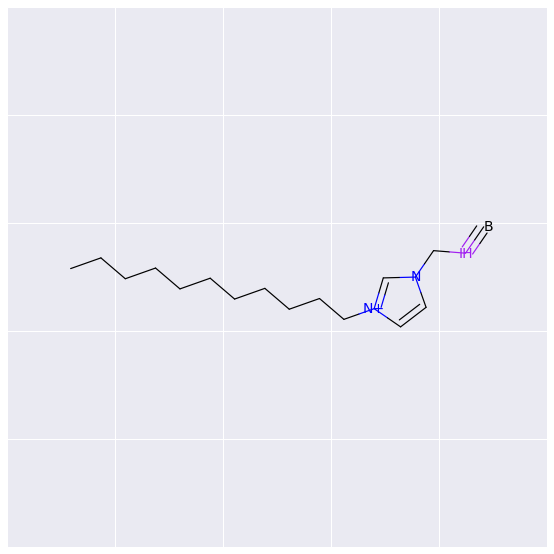

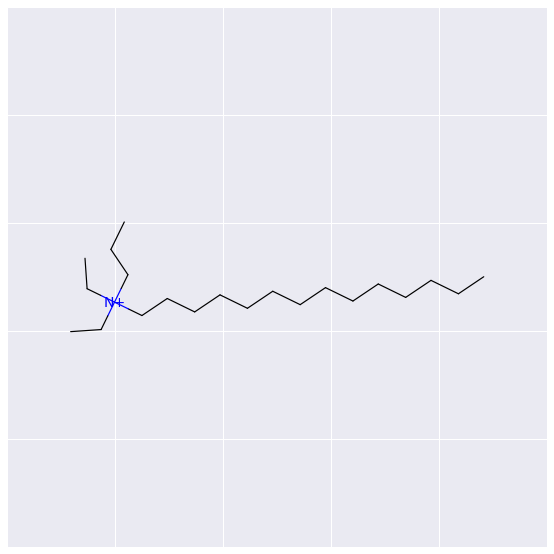

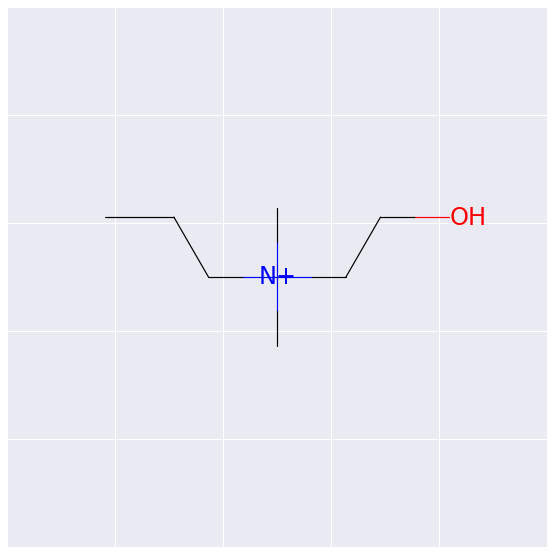

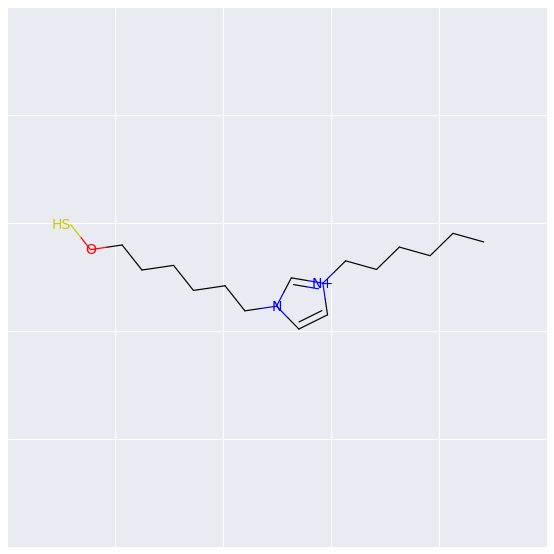

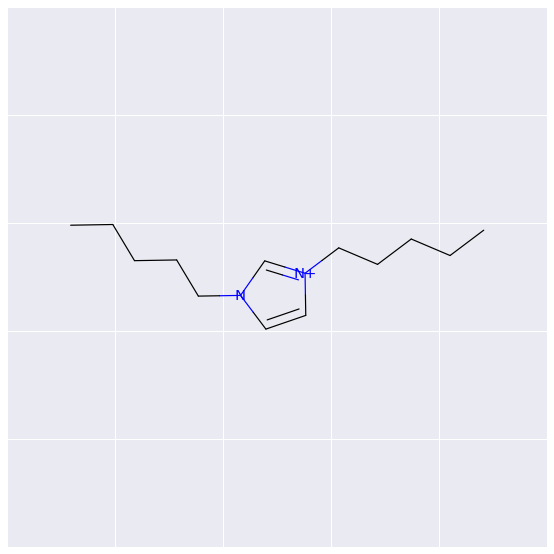

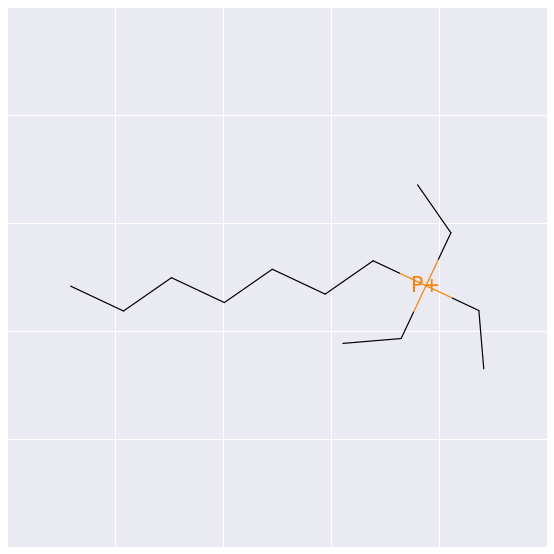

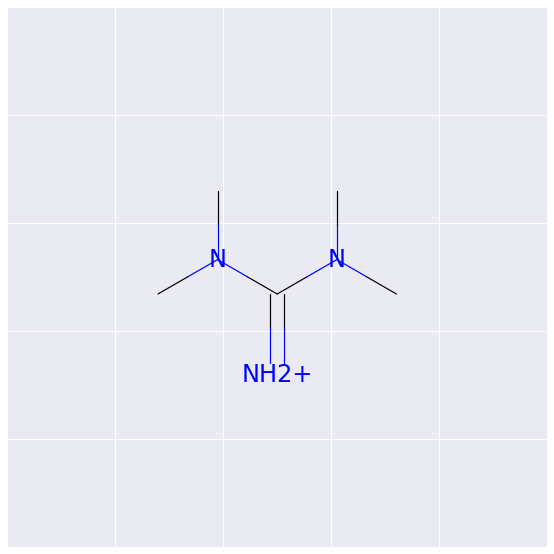

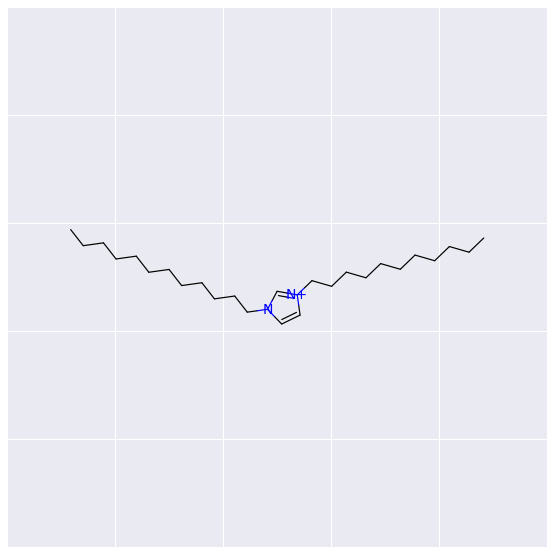

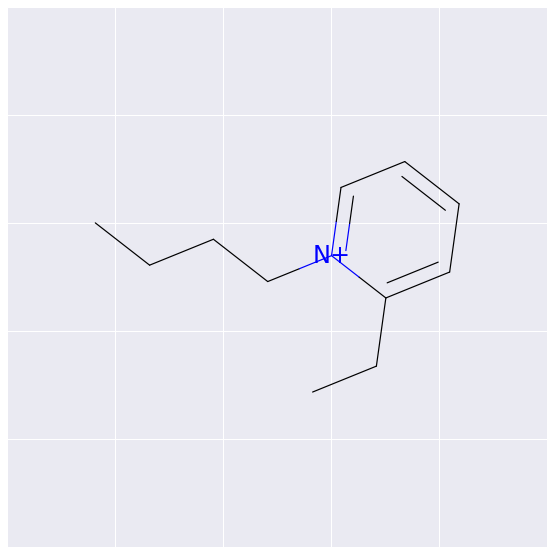

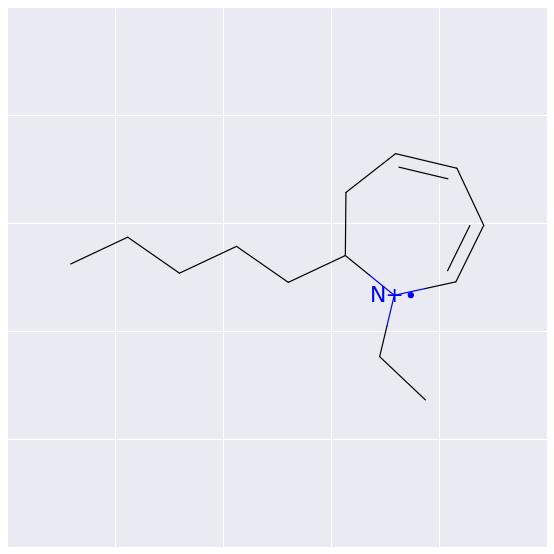

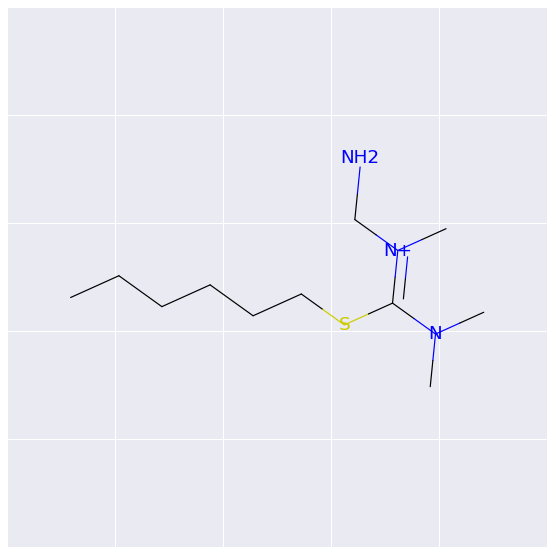

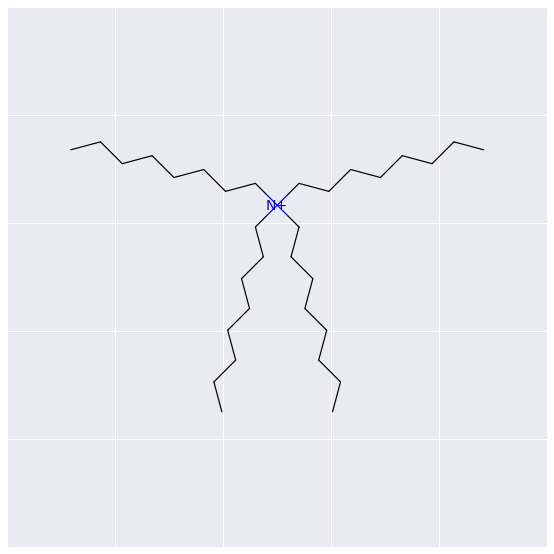

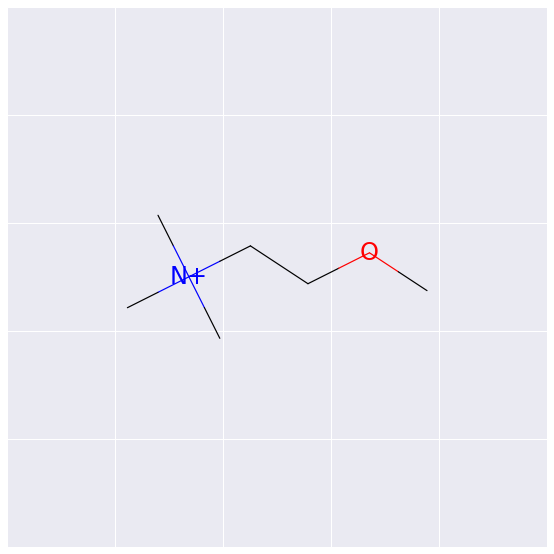

In [32]:
cation_samples = []
cation_index = []
for smi_index, smi in enumerate(cations):
    smi = pad_smiles(smi, smile_max_length)
    Z = np.zeros((1, smile_max_length, len(char_list)), dtype=np.bool)
    for t, char in enumerate(smi):
        Z[0, t, char_to_index[char]] = 1
    attempts=0
    while True:
        attempts += 1
        string = ""
        for i in autoencoder.predict(Z):
            for j in i:
                t = random.random()
                index = sample(j, temperature=t)
                string += index_to_char[index]
        try:
            Draw.MolToMPL(Chem.MolFromSmiles(string))
            cation_samples.append(string)
            cation_index.append(smi_index)
            break
        except:
            if attempts > 10:
                break
            else:
                continue

In [33]:
cation_samples

['CCCC[n+]1ccc(cc1)C#N P]\\HIPH5cr8)Nr+lN)IFFH+++5FB\\S',
 'CCCCn1cc[n+](c1C)CO lro]#H4[( 4\\7=82FlOc[=o l42[P3I',
 'C(CO)[NH2+]CCOC  2NnHc7\\6[rc+]65F[35O[+S8PBF-1664=4',
 'C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC 6CP\\5+)1',
 'n1cc[n+](cc1)C -5H\\[Hn BScs(5353S-)+IP]++H-o+ssn5[I',
 'CC[N+](CC)(CC)CCCCCCC 66rB8BCCc1#nI[n6\\ o B  #=1P+4',
 'CCC[N+](C)(C)CCCCCl 761+)78S7)P(84lcroIP)5l8NrOF3)c',
 'c1cn(c([n+]1CCCc2ccccc2))C=I N8Ol3+7lc-F\\#[lP#P1S2)',
 'c1c[n+](cn1CCCCCCCCC)C rSc#I(\\sH3c-l28CrH #27S-3+F)',
 'CCCC[N+]1(CCCCC)CCOP1N S)==8oO8r58(5r(o4]ro)rFB7H=[',
 'CCCCCCCCCCCCn1cc[n+](c1)CCCCCCCCCCCC SFroF=-B74)3=-',
 'c1cc[n+](cc1)CCOS IFH)\\SO(+8F1\\([#n+]7658+=n+n6\\ ( ',
 'CCCCC[n+]1ccccc1IPO sC=rO21sF57sB\\(r ]SB1=[Hr=84\\n-',
 'C[n+]1ccn(c1)CC=C )857O#)6251nc[HSInB5lo2(6s436(r2[',
 'C[n+]1ccn(c1)CC=C H6P4l2#23]1n]-=3\\n 1N=l#8F=-[58n-',
 'C1=C[N+](CC(CBr)N=[N+]=[N-])=CN1CN 373B6B3CrHHs#\\l(',
 'CCC[NH+](C)CCC-I 3]+c+++\\-\\1-)2 S8sCr67s+3B]BP5--rs',
 'C1=C[N+](CCC#N)=CN1CCCCC Is-